In [1]:
import gym
import tensorflow as tf


C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [3]:
import numpy as np
import pandas as pd

In [4]:
import timeit

In [5]:
env = gym.make("Taxi-v2")

In [6]:
# def create_net(input_state, variable_scope, layer_list, trainable, action_num):
#     with tf.variable_scope(variable_scope):
#         w_initialiser = tf.random_normal_initializer(mean=0., stddev=0.01)
# #         layer1 = tf.layers.Dense(units=500, activation=tf.nn.relu,
# #                                  name="layer", trainable=trainable,
# #                                 kernel_initializer=w_initialiser)
# #         layer_list.append(layer1)
# #         layer1_output = layer1(input_state)
# #         layer2 = tf.layers.Dense(units=5, activation=tf.nn.relu,
# #                                  name="layer", trainable=trainable)
# #         layer_list.append(layer2)
# #         layer2_output = layer2(layer1_output)
#         output_layer = tf.layers.Dense(units=action_num, name="layer", 
#                                        trainable=trainable, kernel_initializer=w_initialiser,
#                                        activation=None
#                                       )
#         layer_list.append(output_layer)
#         output = output_layer(input_state)

#         return output
    
def create_net(input_state, variable_scope, variable_list, trainable):
    with tf.variable_scope(variable_scope):
        
        weights_1 = tf.get_variable(name="w1",
#                                     initializer=tf.random_uniform([env.observation_space.n, 6],0,0.001),
                                    initializer=tf.random_normal(shape=[env.observation_space.n, 6], mean=0, stddev=2/env.observation_space.n),
                                    trainable=trainable
                                   )
        variable_list.append(weights_1)
#         weights_2 = tf.get_variable(name="w2",
# #                                     initializer=tf.random_uniform([6, env.action_space.n],0,0.001),
#                                     initializer=tf.random_normal(shape=[6, env.action_space.n], mean=0, stddev=2/(env.observation_space.n** 2)),
#                                     trainable=trainable
#                                    )
#         variable_list.append(weights_2)
#         bias = tf.get_variable(name="b1",
#                                shape=[6],
#                                initializer=tf.constant_initializer(0.001),
#                                trainable=trainable
#                               )
#         variable_list.append(bias)

#         layer1_output = tf.nn.relu(tf.matmul(input_state, weights_1) + bias)
        
#         output = tf.matmul(layer1_output, weights_2)
        output = tf.matmul(input_state, weights_1)
        
        return output

In [7]:
def copy_net(dest_list, src_list, sess):
    for predict_variable, target_variable in zip(src_list, dest_list):
        assign_op = tf.assign(ref=target_variable, value=predict_variable)
        sess.run(assign_op)

## Create the neural network
---

In [8]:
tf.reset_default_graph()

In [9]:
predict_input_state_tf = tf.placeholder(shape=(None, env.observation_space.n), dtype= tf.float32, name="predict_input_state")
target_input_state_tf = tf.placeholder(shape=(None, env.observation_space.n), dtype=tf.float32, name="target_input_state")


In [10]:
predict_variable_list = []
predict_q_values_tf = create_net(predict_input_state_tf, variable_scope="predict_net",
                                 variable_list=predict_variable_list, trainable=True)

predict_action_tf = tf.argmax(predict_q_values_tf, axis=1)

In [11]:
target_variable_list = []
target_q_values_tf = create_net(target_input_state_tf, variable_scope="target_net",
                                 variable_list=target_variable_list, trainable=False)

In [12]:
gradients_op_list = []
y_tf = tf.placeholder(shape=(None, env.action_space.n), dtype=tf.float32)

with tf.variable_scope("loss"):
    loss_tf = tf.losses.mean_squared_error(labels=y_tf, predictions=predict_q_values_tf)

#     loss_tf = tf.reduce_sum(tf.squared_difference(y_tf, predict_q_values_tf))
with tf.variable_scope("train"):
#     my_optimiser = tf.train.GradientDescentOptimizer(2.2)
    my_optimiser = tf.train.RMSPropOptimizer(learning_rate = 0.1, momentum=0.6)
    train_op = my_optimiser.minimize(loss_tf)
#     for variables in predict_variable_list:
#         gradients_op_list.append(my_optimiser.compute_gradients(loss_tf, var_list=variables))
    grads_and_vars_op = my_optimiser.compute_gradients(loss_tf, var_list=predict_variable_list)

## Set up hyperparameters

In [175]:
max_random_probability = 1.0
min_random_probability = 0
mem_size = 3000
update_epoches = 100
batch_size = 32
gamma = 0.99
one_hot_state = np.identity(env.observation_space.n)

In [176]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

## Start training the network

In [177]:
loss_list = []
reward_list = []
steps_list = []
gradient_list = []
mean_variable_list = []
std_variable_list = []

episode_num = 1000
all_step_counter = 0
random_probability_distribution = np.linspace(max_random_probability, min_random_probability, episode_num * 0.95)

start = timeit.default_timer()

for i in range(episode_num):
    done = False
    episode_reward = 0
    current_state = env.reset()
    step_counter = 0
    random_probability = random_probability_distribution[i] if i < len(random_probability_distribution) else min_random_probability
    while step_counter < 100: # If agent cannot find the solution in 50 steps reset the environment
        [action], predict_q_values = sess.run([predict_action_tf, predict_q_values_tf],
                                              feed_dict={
                                                  predict_input_state_tf: one_hot_state[current_state: current_state + 1]
                                              })        
        
        if np.random.uniform() <= random_probability:
            # Randomly explore the world
            action = env.action_space.sample()
        
        # Execute the action and observe the reward
        next_state, reward, done, info = env.step(action)

        # If we don't use the target network
        next_q_values = sess.run(predict_q_values_tf, feed_dict={
            predict_input_state_tf: one_hot_state[next_state: next_state + 1]
        })

        # Pick the max q value for next state
        max_next_q_value = np.max(next_q_values)
        # Take the other actions q values
        y = predict_q_values
        # Update the right we performed only
        y[0, action] = reward + gamma * max_next_q_value

        # Learn
        _, grads_and_vars,loss = sess.run([train_op, grads_and_vars_op, loss_tf], feed_dict={
            predict_input_state_tf: one_hot_state[current_state: current_state + 1],
            y_tf: y
        })

        loss_list.append(loss)
        for pair in grads_and_vars:
            gradient_list.append(np.mean(pair[0]))
            mean_variable_list.append(np.mean(pair[1]))
            std_variable_list.append(np.std(pair[1]))
        
        current_state = next_state
        
        episode_reward += reward
        step_counter += 1
        
        if i > episode_num - 5:
            env.render()
            print(loss)
        
        if done == True:
            break
    
    
    reward_list.append(episode_reward)
    steps_list.append(step_counter)
    
    if(i and i%200==0):
        print("Episode: {0},  step: {1}, random: {2}".format(i, step_counter, random_probability))
        
end = timeit.default_timer()

print("Time usage: ", end - start)

C:\Users\Admin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


Episode: 200,  step: 52, random: 0.7892518440463646
Episode: 400,  step: 80, random: 0.5785036880927292
Episode: 600,  step: 15, random: 0.36775553213909384
Episode: 800,  step: 24, random: 0.15700737618545846
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
1.987862
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
15.592826
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
1.4608059
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
143.43697
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
2.1955836
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
208.62471
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
105.15337
+---------+
|R: | : :G|
| : : : : |
| : : : : |
|_| : | : |
|Y

## Evaluate the performance

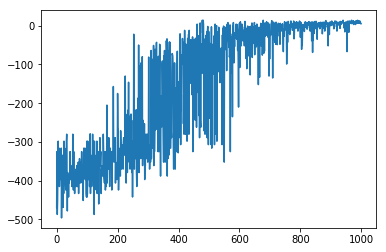

In [178]:
plt.plot(reward_list)

In [179]:
np.mean(reward_list)

-149.248

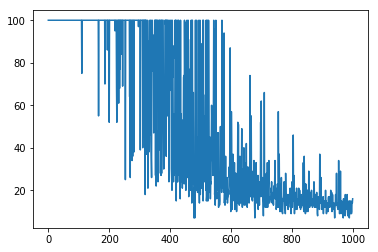

In [180]:
plt.plot(steps_list)

In [181]:
np.mean(steps_list)

52.966

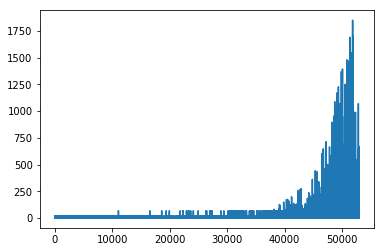

In [182]:
plt.plot(loss_list)

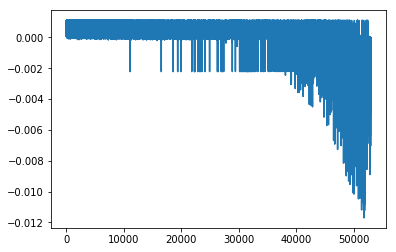

In [183]:
plt.plot(gradient_list)

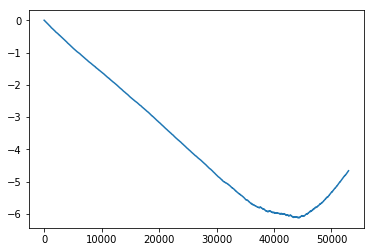

In [184]:
plt.plot(mean_variable_list)

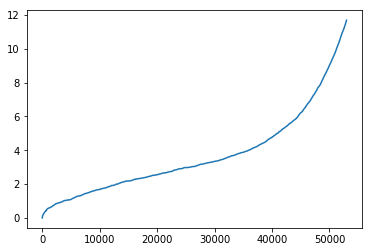

In [185]:
plt.plot(std_variable_list)

## Evaluate with the real q table

In [20]:
import pickle

q_table = pickle.load(open("obj/q_table.pkl", "rb"))

Using the `DQN` predicts the whole table

In [21]:
predict_q_table = sess.run(predict_q_values_tf, feed_dict={predict_input_state_tf: one_hot_state})

In [22]:
np.mean(np.absolute(predict_q_table - q_table))

161.66234543985843